In [19]:
import dynamiqs as dq
import jax
import jax.numpy as jnp # the JAX version of numpy
from matplotlib import pyplot as plt

# Problem 1

## Problem 1.1

$$
\begin{aligned}
\hat{H} &= \hat{H}_{\mathrm{2ph}} + \hat{H}_d,\qquad \mathrm{with}\\
\hat{H}_{\mathrm{2ph}} &= g_2 {{}\hat{a}^\dagger}^2 \hat{b} + g_2^* \hat{a}^2 \hat{b}^\dagger,\\
\hat{H}_d &= \epsilon_d^* \hat{b} + \epsilon_d \hat{b}^\dagger.
\end{aligned}
$$

In [71]:
# parameters
na = 20  # number of Fock states for a
nb = 5  # number of Fock states for b
T = 4  # length of the simulation
omega = jnp.pi/T  # frequency of the oscillator
eps = -4 # coupling strength
Kb = 10 # kappa in the paper
numTimes = 1000


In [72]:
# annihilation operators
a, b = dq.destroy(na, nb)
# dims of above are na*nb
g2 = 1 # coupling strength

Hbuff = g2 * dq.dag(a) @ dq.dag(a) @ b  + jnp.conj(g2) * a @ a @ dq.dag(b) + jnp.conj(eps) * b + eps * dq.dag(b)
# Hamiltonian with full buffer simulation

In [73]:
# initial state
psi0 = dq.fock((na,nb), (0,0))  # vacuum state
t_save = jnp.linspace(0, T, 1000)  # time points to save the state

jump_ops = [jnp.sqrt(Kb)*b] # jump operators
exp_ops = [dq.dag(a) @ a] # expectation operators
res = dq.mesolve(Hbuff,jump_ops, psi0, t_save, exp_ops=exp_ops) # solve the master equation

trace_a = dq.ptrace(res.states, 0,res.states.dims) # partial trace over b

# dq.plot.wigner_gif(trace_a, fps=120) # plot the Wigner function of the partial trace


|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

In [23]:


numOp = dq.tensor(dq.number(na), dq.eye(nb))

def parity(n):
    diag = jnp.array([(-1)**i for i in range(n)], dtype=jnp.complex128)
    return diag

# Create a diagonal matrix from the parity vector.
parity_diag_matrix = jnp.diag(parity(na))

# to a Qarray.
Pa_a = dq.asqarray(parity_diag_matrix, dims=(na,))


Ib = dq.eye(nb)

PaOp = dq.tensor(Pa_a, Ib)


# expectation value of the photons




|██████████| 100.0% ◆ elapsed 347.18ms ◆ remaining 0.00ms  
/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_96430/1200739366.py:4: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in array is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  diag = jnp.array([(-1)**i for i in range(n)], dtype=jnp.complex128)


|█▉        |  19.4% ◆ elapsed 64.01ms ◆ remaining 0.00ms

|          |   0.2% ◆ elapsed 7.01ms ◆ remaining 0.00ms

|          |   0.2% ◆ elapsed 20.26ms ◆ remaining 0.00ms

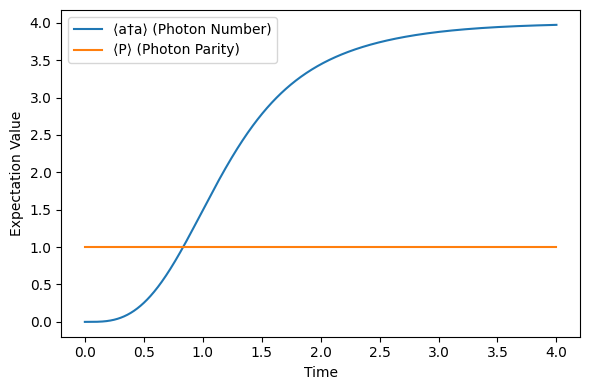

In [ ]:
num_expect = []
parity_expect = []

for state in res.states:
    num_val = dq.expect(numOp, state).real  
    # <state|num|state>
    parity_val = dq.expect(PaOp, state).real  
    # <PaOp|num|PaOp>
    num_expect.append(num_val)
    parity_expect.append(parity_val)

num_expect = jnp.array(num_expect)
parity_expect = jnp.array(parity_expect)

# Now plot the observables versus time (assuming t_save is your array of times):
t_save = jnp.linspace(0, 4, len(res.states))  # or your actual t_save array

plt.figure(figsize=(6,4))
plt.plot(t_save, num_expect, label="⟨a†a⟩ (Photon Number)")
plt.plot(t_save, parity_expect, label="⟨P⟩ (Photon Parity)")
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
psi0.shape

(100, 1)

## Task 1.2
We now want to find the distance between the new operator norm and  $\hat{\rho}$, 

In [63]:
import numpy as np


alpha = np.sqrt(-eps/(g2.conjugate()))
alpha
Ia = dq.eye(na)
Ib = dq.eye(nb)
a_tensored = a
adag_tensored = dq.dag(a)
b_tensored = b
bdag_tensored = dq.dag(b)


I = dq.tensor(dq.eye(nb),dq.eye(na))
psi0a = dq.coherent(na, 0)  # vacuum state for mode a
psi0b = dq.coherent(nb, 0)  # vacuum state for mode b
psi0 = dq.tensor(psi0a, psi0b)
tsave = jnp.linspace(0,T,numTimes)
psi0.shape

(100, 1)

In [64]:
a_tensored.shape

(100, 100)

In [27]:
rho_a_list = [state for state in res.states]
def fidelity(kappaB):
    kappaB = 10
    kappa2 = 4*abs(g2)**2/kappaB

    jumpOperator = [jnp.sqrt(kappa2) * (a_tensored @ a_tensored - alpha**2*dq.tensor(dq.eye(na), dq.eye(nb)))]
    # D = dq.tensor(D_memory,Ib)
    # jump_ops = [jnp.sqrt(kappa2)*()]
    # For example, extract the underlying dense representation (if accessible)
    # and re-wrap it with the proper dims.
    Hzero = dq.tensor(dq.zeros(na), Ib)
    

    onePointTwo = dq.mesolve(Hzero,jumpOperator,psi0,tsave)
    # We only need a zero hamiltonian because we're not coupled to the outside
    # anymore
    onePointTwoList = [state for state in onePointTwo.states]
    fidelities = []
    for rho_full, rho_eff in zip(rho_a_list, onePointTwoList):
        fid = dq.fidelity(rho_full, rho_eff)
        fidelities.append(fid)
    fidelities = jnp.array(fidelities)
    return fidelities

In [28]:
fidelities=fidelity(10)

/Users/amer_/Documents/Obsidian Vault/Personal/Project Notes/Hackathon/iQuHack/lib/python3.12/site-packages/dynamiqs/qarrays/qarray.py:484: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return self + (-y)
|██████████| 100.0% ◆ elapsed 552.79ms ◆ remaining 0.00ms  


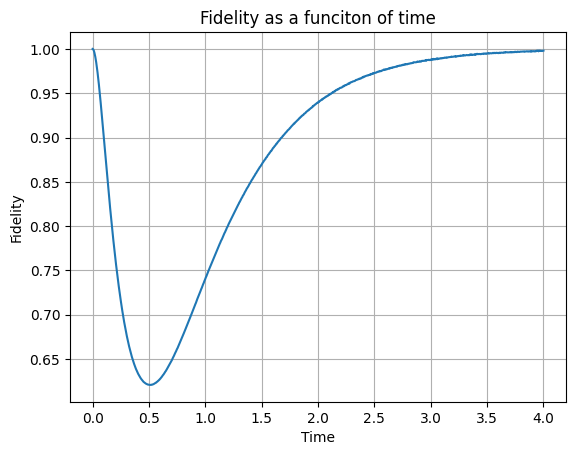

In [29]:
plt.plot(tsave,fidelities)
plt.ylabel("Fidelity")
plt.xlabel("Time")
plt.title("Fidelity as a funciton of time")
plt.grid()

### Analysis of 1.2
We observed that by changing the $k_B$ over time, that the local minimum of the function wouldn't change. However, the curve seemed to be more strongly damped in the sense that returning to a fidelity of one took longer.
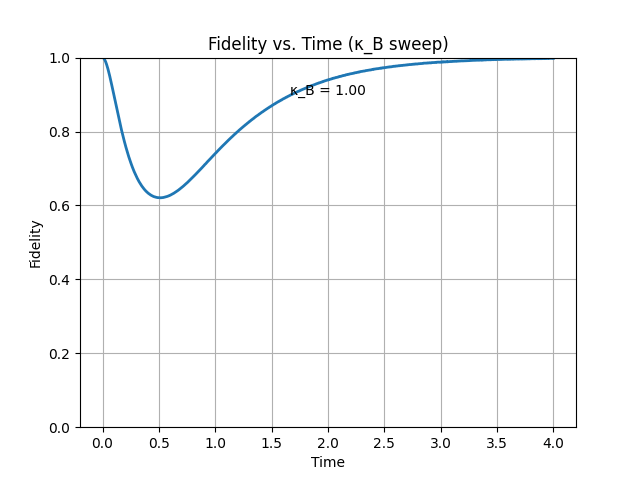

Looks like a leanord jones potential. It starts at the exact same state, then quickly falls to zero. Then somehow we slowly correct back to one

https://www.dynamiqs.org/stable/documentation/getting_started/sharp-bits.html
https://www.dynamiqs.org/stable/python_api/solver/Expm.html
https://www.dynamiqs.org/stable/python_api/utils/general/fidelity.html#dynamiqs.utils.general.fidelity
https://www.dynamiqs.org/stable/python_api/utils/operators/displace.html#dynamiqs.utils.operators.displace
https://www.dynamiqs.org/stable/documentation/advanced_examples/kerr-oscillator.html


https://www.dynamiqs.org/stable/documentation/getting_started/sharp-bits.html
https://www.dynamiqs.org/stable/python_api/solver/Expm.html
https://www.dynamiqs.org/stable/python_api/utils/general/fidelity.html#dynamiqs.utils.general.fidelity
https://www.dynamiqs.org/stable/python_api/utils/operators/displace.html#dynamiqs.utils.operators.displace
https://www.dynamiqs.org/stable/documentation/advanced_examples/kerr-oscillator.html


## Task 1.3 

|██████████| 100.0% ◆ elapsed 2.33s ◆ remaining 0.00ms  


==== MESolveResult ====
Solver : Tsit5
Infos  : 1482 steps (1475 accepted, 7 rejected)
States : QArray complex64 (1000, 100, 100) | 76.3 Mb


100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


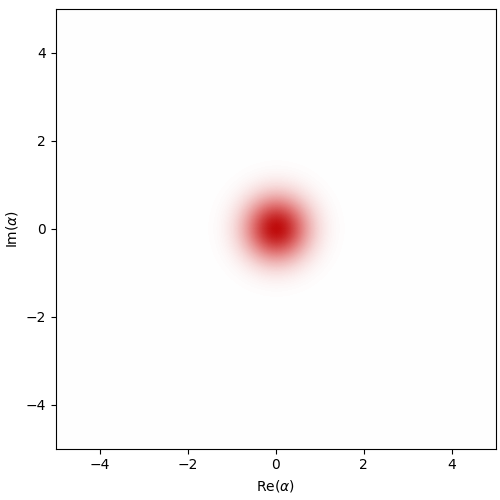

In [75]:
epsilon_z =1+1j

H_zeno = epsilon_z.conjugate()*a_tensored+epsilon_z*adag_tensored
jump_ops = [a_tensored- alpha*dq.tensor(dq.eye(na), dq.eye(nb))]

H_zeno+=Hbuff
result = dq.mesolve(H_zeno, jump_ops,psi0, t_save)
print(result)
dq.plot.wigner_gif(result.states, gif_duration = 2, fps = 25)

In [76]:
a_tensored.shape

(100, 100)

In [77]:
H_zeno.shape

(100, 100)

In [78]:
def danieltest(epsilon):

    H = epsilon_z.conjugate()*a_tensored+epsilon_z*adag_tensored
    dq.plot.wigner_gif(result.states, gif_duration = 2, fps = 25)

danieltest(1+np.pi*1j)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  6.81it/s]


# Problem 2


In [ ]:
import dynamiqs as dq
import jax.numpy as jnp

# Corrected Parameters with Units
GHz = 1e9
MHz = 1e6
h = 6.62607015e-34  

# Frequencies (converted to rad/s)
wa0 = 5.26 * GHz * 2 * jnp.pi  # 5.26 GHz to rad/s
wb0 = 7.7 * GHz * 2 * jnp.pi
omegaP = 2.891 * GHz * 2 * jnp.pi
wD = 7.623 * GHz * 2 * jnp.pi

# E_J and ΔE_J in rad/s (E_J / ħ)
E_J_Hz = 42.76 * GHz
E_J_rads = E_J_Hz * 2 * jnp.pi
delEJ_Hz = 0.47 * GHz
delEJ_rads = delEJ_Hz * 2 * jnp.pi

# Drive and pump parameters
epsD = -3.815 * MHz * 2 * jnp.pi  # ε_d in rad/s
epsP = 0.122  # radians (dimensionless)

# Dissipation rates (from paper: κ_a/2π=0.05 MHz, κ_b/2π=5 MHz)
kappa_a = 0.05 * MHz * 2 * jnp.pi  # rad/s
kappa_b = 5 * MHz * 2 * jnp.pi      # rad/s

# Hilbert space truncation
n_a, n_b = 20, 5




# Phi operator
phi_a_val = 0.06
phi_b_val = 0.29
phi = phi_a_val * (a_tensored + adag_tensored) + phi_b_val * (b_tensored + bdag_tensored)

# Jump operators
jump_ops = [
    jnp.sqrt(kappa_b) * b_tensored,
    jnp.sqrt(kappa_a) * a_tensored
]

# Initial state: vacuum
psi0 = dq.tensor(dq.fock(n_a, 0), dq.fock(n_b, 0))

# Time parameters
T = 1e-6  # 1 μs (adjust as needed)
num_steps = 1000
t_save = jnp.linspace(0, T, num_steps)

# Hamiltonian function with corrected expansions
def H_func(t):
    eps_t = epsP * jnp.cos(omegaP * t)
    
    Hd = 2 * epsD * jnp.cos(wD * t) * (b_tensored + bdag_tensored)
    
    # Corrected expansions for sin(φ) and cos(φ)
    # Replace divisions in operator expressions with multiplication by reciprocals
    

    # Corrected H_ATS construction
    H_ATS = (
        -2 * E_J_rads * jnp.sin(eps_t) * sin_phi_approx
        + 2 * delEJ_rads * jnp.cos(eps_t) * cos_phi_approx
    )

# Ensure all operator terms use * for scalar multiplication
    
    return H0 + Hd + H_ATS

# Run the simulation
result = dq.mesolve(
    dq.timecallable(H_func),
    jump_ops,
    psi0,
    t_save,
)

# Proceed with plotting and analysis

NameError: name 'sin_phi_approx' is not defined

In [24]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# =============================================================================
# PARAMETERS (from the paper)
# =============================================================================
GHZ = 1e9  # 1 GHz in Hz units
MHz = 1e6  # 1 MHz in Hz units

# Frequencies and energies (in rad/s, note the conversion: 2*pi factor)
wa0 = 5.26 * GHZ * 2 * jnp.pi         # Memory mode bare frequency
wb0 = 7.70 * GHZ * 2 * jnp.pi         # Buffer mode bare frequency
omega_d = 7.623 * GHZ * 2 * jnp.pi      # Drive frequency (buffer)
omega_p = 2.891 * GHZ * 2 * jnp.pi      # ATS pump frequency

# ATS parameters
# E_J/h is given in GHz, so to obtain E_J in rad/s, multiply by h and 2pi if needed.
h = 6.626e-34
E_J = 42.76 * GHZ * h                 # Josephson energy (in Joule, may require rescaling)
delEJ = 0.47 * GHZ                    # Delta E_J (in Hz, but note units)

# Drive amplitude (epsilon_d) is given in MHz (2pi factor to rad/s)
epsD = -3.815 * MHz * 2 * jnp.pi      # Drive amplitude for buffer
# Flux pump amplitude:
epsP = 0.122                        # in radians

# Other parameters for the ATS potential: participation factors
phi_a = 0.06
phi_b = 0.29

# Dissipation rates (example values; adjust as needed)
kappa_a = 1e6   # for memory mode, in rad/s
kappa_b = 2e6   # for buffer mode, in rad/s

# Total simulation time: choose T (e.g., 4 microseconds)
T_sim = 4e-6

# Hilbert space truncation:
na = 20   # memory mode
nb = 5    # buffer mode

# =============================================================================
# SET UP OPERATORS IN THE COMPOSITE SPACE
# =============================================================================

# Create annihilation operators for mode a and b:
a = dq.destroy(na)
b = dq.destroy(nb)
Ia = dq.eye(na)
Ib = dq.eye(nb)

# Embed them into the composite space:
a_tensored = dq.tensor(a, Ib)      # acts on memory mode
adag_tensored = dq.dag(a_tensored)
b_tensored = dq.tensor(Ia, b)        # acts on buffer mode
bdag_tensored = dq.dag(b_tensored)

# Define the flux operator:
#   φ̂ = φ_a (a + a†) + φ_b (b + b†)
phi = phi_a * (a_tensored + adag_tensored) + phi_b * (b_tensored + bdag_tensored)

# =============================================================================
# TASK 2.1: LAB-FRAME SIMULATION
# =============================================================================

# Define the static part H0:
H0_static = wa0 * (a_tensored @ adag_tensored) + wb0 * (b_tensored @ bdag_tensored)

# Define the ATS part in the lab frame.
# eps(t) = epsP * cos(omega_p * t)
def ats_lab(t):
    eps_t = epsP * jnp.cos(omega_p * t)
    # Use dq.sinm and dq.cosm to evaluate operator sine and cosine of φ.
    sin_phi = dq.sinm(phi)
    cos_phi = dq.cosm(phi)
    term1 = -2 * E_J * jnp.sin(eps_t) * sin_phi
    term2 =  2 * delEJ * jnp.cos(eps_t) * cos_phi
    return term1 + term2

H_ATS_lab = dq.timecallable(ats_lab)

# Define the drive term for the buffer in the lab frame:
def drive_lab(t):
    return 2 * epsD * jnp.cos(omega_d * t) * (b_tensored + bdag_tensored)

H_d_lab = dq.timecallable(drive_lab)

# Total lab-frame Hamiltonian:
H_lab = dq.constant(H0_static) + H_ATS_lab + H_d_lab

# Define jump operators in the composite space:
jump_ops = [
    jnp.sqrt(kappa_a) * a_tensored,
    jnp.sqrt(kappa_b) * b_tensored
]

# Initial state: both modes in vacuum.
psi0_a = dq.fock(na, 0)
psi0_b = dq.fock(nb, 0)
psi0 = dq.tensor(psi0_a, psi0_b)

# Time grid for simulation:
t_save = jnp.linspace(0, T_sim, 101)

# Run the lab-frame simulation:
result_lab = dq.mesolve(H_lab, jump_ops, psi0, t_save)

# Plot the Wigner function evolution for mode a:
# We extract the reduced density matrix for mode a via partial trace over mode b.
rho_a_lab = [dq.partial_trace(state, subsystem=1) for state in result_lab.states]
dq.plot.wigner_gif(rho_a_lab, fps=24)
plt.title("Wigner evolution (Lab frame)")
plt.show()

# =============================================================================
# TASK 2.2: ROTATED-DISPLACED FRAME SIMULATION
# =============================================================================

# In the rotated-displaced frame, the goal is to remove the fast oscillating drive on mode b.
# For mode b, the displacement amplitudes ξ_{a/b}(t) are given approximately by:
#    ξ_{a/b}(t) ≈ -i * (E_J * epsP * φ_{a/b} * exp(-i ω_p t)) / (κ_{a/b}/2 + i(ω_{a/b,0} - ω_p))
# Here we focus on constructing the transformed Hamiltonian (up to the two-photon term).
# For simplicity, we assume that the rotated-displaced Hamiltonian for the full system is given by:
# 
#   H_rot ≈ (ω_a - (ω_p+ω_d)/2) a†a + (ω_b - ω_d) b†b 
#           + g2^* a^2 b† + g2 (a†)^2 b,
#
# where g2 = E_J * epsP * φ_a^2 * φ_b.
# We then use dq.constant to form the static terms.
#
# Define effective frequencies in the rotated frame:
omega_a_eff = wa0 - (omega_p + omega_d) / 2.0
omega_b_eff = wb0 - omega_d

# Define the two-photon exchange terms:
# Note: We assume g2 is given by:
g2 = E_J * epsP * (phi_a ** 2) * phi_b
# Construct operators for the two-photon exchange on the composite space:
H_2ph = g2.conjugate() * (a_tensored @ a_tensored @ bdag_tensored) \
       + g2 * (adag_tensored @ adag_tensored @ b_tensored)

# Construct the effective free Hamiltonian in the rotated frame:
H_free_rot = omega_a_eff * (a_tensored @ adag_tensored) + omega_b_eff * (b_tensored @ bdag_tensored)

# The total Hamiltonian in the rotated-displaced frame (RWA) is:
H_rot = dq.constant(H_free_rot) + dq.constant(H_2ph)

# For this simulation, assume the same jump operators and initial state.
result_rot = dq.mesolve(H_rot, jump_ops, psi0, t_save)

# Plot the Wigner function evolution for mode a in the rotated-displaced frame:
rho_a_rot = [dq.partial_trace(state, subsystem=1) for state in result_rot.states]
dq.plot.wigner_gif(rho_a_rot, fps=24)
plt.title("Wigner evolution (Rotated-displaced frame)")
plt.show()

# =============================================================================
# TASK 2.3: Compare with the Effective Model
# =============================================================================

# Assume that in Task 1.1 you have simulated an effective model in which the memory mode evolves with:
#    dρ_a/dt = κ_2 D[a^2 - α^2](ρ_a)
# with κ_2 = 4|g2|^2 / κ_b and α^2 = -epsD / g2^*.
# We now simulate that effective model for the memory mode alone.

# Define effective parameters:
kappa2 = 4 * abs(g2)**2 / kappa_b
alpha_sq = -epsD / g2.conjugate()

# Create the effective jump operator on mode a:
Ia_eff = dq.eye(na)
L_eff = jnp.sqrt(kappa2) * (a @ a - alpha_sq * Ia_eff)
jump_ops_eff = [L_eff]

# Effective Hamiltonian for the memory mode is zero:
H_eff = dq.zeros(na)
psi0_eff = dq.fock(na, 0)  # memory mode vacuum

# Simulate the effective model:
result_eff = dq.mesolve(H_eff, jump_ops_eff, psi0_eff, t_save)

# Now compute the fidelity between the reduced state (from the full rotated-displaced simulation)
# and the state from the effective model, at each time.
fidelities = []
for rho_full, rho_eff in zip(rho_a_rot, result_eff.states):
    fid = dq.fidelity(rho_full, rho_eff)
    fidelities.append(fid)
fidelities = jnp.array(fidelities)

plt.figure(figsize=(6,4))
plt.plot(t_save, fidelities, label="Fidelity")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity between Rotated-displaced model and Effective model")
plt.legend()
plt.show()

# =============================================================================
# TASK 2.4: Optimal Control (Open-ended)
# =============================================================================
# Here you are invited to explore further optimizations.
# For example, you could vary parameters such as:
# - The ATS drive amplitude (epsP)
# - The buffer drive amplitude (epsD)
# - External flux biases (phi_a, phi_b)
#
# One could set up a cost function (for instance, the fidelity with a target cat state)
# and then use jax.grad to compute gradients with respect to these parameters.
#
# This section is left open for your exploration.


/Users/amer_/Documents/Obsidian Vault/Personal/Project Notes/Hackathon/iQuHack/lib/python3.12/site-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
|          |   0.0% ◆ elapsed 12.63ms ◆ remaining 0.00ms

AttributeError: module 'dynamiqs' has no attribute 'partial_trace'

|██████████| 100.0% ◆ elapsed 07m53s ◆ remaining 0.00ms   
ERROR:2025-02-01 19:01:08,226:jax._src.callback:97: jax.pure_callback failed
Traceback (most recent call last):
  File "/Users/amer_/Documents/Obsidian Vault/Personal/Project Notes/Hackathon/iQuHack/lib/python3.12/site-packages/jax/_src/callback.py", line 95, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/Users/amer_/Documents/Obsidian Vault/Personal/Project Notes/Hackathon/iQuHack/lib/python3.12/site-packages/jax/_src/callback.py", line 72, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/amer_/Documents/Obsidian Vault/Personal/Project Notes/Hackathon/iQuHack/lib/python3.12/site-packages/equinox/_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: The maximum numbe